# 2. Data fetching and processing

In [1]:
import sys
from pathlib import Path
sys.path.append(str(Path("../../").resolve()))

%load_ext autoreload
%autoreload 2

## More details about list_data

In [4]:
import pipeGEM as pg
from pipeGEM.data.fetching import list_models, load_remote_model

In [4]:
model_list = list_models(organism="human")

In [5]:
model_list

,id,organism,reaction_count,metabolite_count,gene_count,database
1,Human-GEM,Homo sapiens,13070,8369,3067,metabolic atlas
1,iAB_RBC_283,Homo sapiens,469,342,346,BiGG
12,iAT_PLT_636,Homo sapiens,1008,738,636,BiGG
105,RECON1,Homo sapiens,3741,2766,1905,BiGG
106,Recon3D,Homo sapiens,10600,5835,2248,BiGG


In [9]:
# select by number of components

model_list = list_models(organism="mouse", 
                         max_n_genes=2000, max_n_mets=3000, max_n_rxns=5000)

In [10]:
model_list

,id,organism,reaction_count,metabolite_count,gene_count,database
77,iMM1415,Mus musculus,3726,2775,1375,BiGG


## Generate simulated gene data

In [2]:
from pipeGEM.data.synthesis import get_syn_gene_data
import seaborn as sns
import numpy as np

In [5]:
mouse = load_remote_model('iMM1415')

Set parameter Username
Academic license - for non-commercial use only - expires 2023-06-14


No objective coefficients in model. Unclear what should be optimized


In [6]:
raw_count = get_syn_gene_data(mouse, n_sample=9, random_state=42)

In [7]:
raw_count.head()

,sample_0,sample_1,sample_2,sample_3,sample_4,sample_5,sample_6,sample_7,sample_8
12846,4163,4115,4058,4072,4153,4135,4012,4068,4004
67689,4063,4141,4117,4145,4061,4110,4091,4031,3938
237940,4093,4152,4121,4003,4050,4168,4133,3974,4053
222,4127,4099,3910,3994,4090,4250,4082,4081,4063
76507,4012,4025,4005,4081,4040,4038,4074,4175,4138


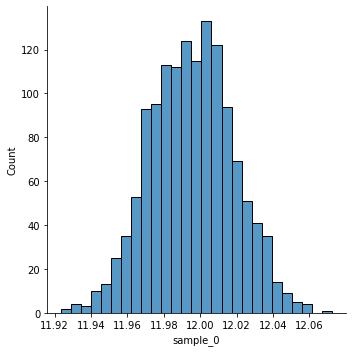

In [8]:
# should be negative binomial distribution

sns.displot(np.log2(raw_count + 1)["sample_0"])

## Maping gene data to a pipeGEM model

In [9]:
from pipeGEM.data import GeneData

In [10]:
p_mouse = pg.Model("imm1415", mouse)

In [11]:
gene_data = GeneData(data=raw_count["sample_0"], 
                     data_transform=lambda x: np.log2(x), 
                     absent_expression=0)

In [12]:
p_mouse.add_gene_data(name_or_prefix="sample_0", 
                      data=gene_data, 
                      or_operation="nanmax",  # alternative: nansum
                      threshold=-np.inf, 
                      absent_value=-np.inf)

In [13]:
p_mouse.reactions.get_by_id("2HBt2")

Reaction identifier,2HBt2
Name,2 hydroxybutyrate cotransport with proton
Memory address,0x0213bc3c7460
Stoichiometry,2hb_e + h_e <=> 2hb_c + h_c 2 Hydroxybutyrate C4H7O3 + H+ <=> 2 Hydroxybutyrate C4H7O3 + H+
GPR,80879 or 20503 or 20501
Lower bound,-100000.0
Upper bound,100000.0


In [14]:
p_mouse.gene_data["sample_0"].rxn_scores["2HBt2"]

11.98299357469431

In [15]:
gene_data.transformed_gene_data["80879"], gene_data.transformed_gene_data["20503"], gene_data.transformed_gene_data["20501"]

(11.98299357469431, 11.972261848733291, 11.971543553950772)

## Finding data thresholds

In [40]:
# modified rFASTCORMICS thresholds
rFASTCORMICS_threshold = gene_data.get_threshold("rFASTCORMICS", return_heuristic=False)

p_score of init values: 0.5008233793152377
original guess:  11.972084763202416 12.004429487212514


C:\Users\qwert\PycharmProjects\pipeGEM\pipeGEM\analysis\_threshold.py:46: RuntimeWarning: overflow encountered in double_scalars
  return c * 2 ** (-abs(x1 - x2)) + (1 - c) * 1.5 ** (((y1 / y2) if y1 > y2 else (y2 / y1)) - 1) / 50


best fitted Amps:  16.57699182633983 1.6946632122639194
best fitted means:  11.996054367924833 11.970684396948442


C:\Users\qwert\PycharmProjects\pipeGEM\pipeGEM\analysis\_threshold.py:169: UserWarning: Fail to optimize: Optimal parameters not found: The maximum number of function evaluations is exceeded.
  warnings.warn(f"Fail to optimize: {e}")


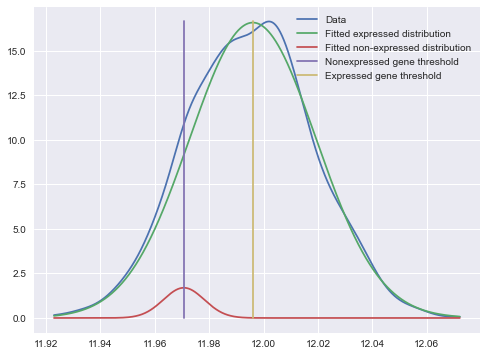

Expression threshold: 11.996054367924833


In [42]:
rFASTCORMICS_threshold.plot()
print(f"Expression threshold: {rFASTCORMICS_threshold.exp_th}")

In [53]:
# percentile thresholds
p90_threshold = gene_data.get_threshold("percentile", p=90)
p75_threshold = gene_data.get_threshold("percentile", p=75)
p50_threshold = gene_data.get_threshold("percentile", p=50)

In [54]:
p50_threshold.exp_th, p75_threshold.exp_th, p90_threshold.exp_th

(11.995060467032719, 12.010178404020541, 12.024793384702548)

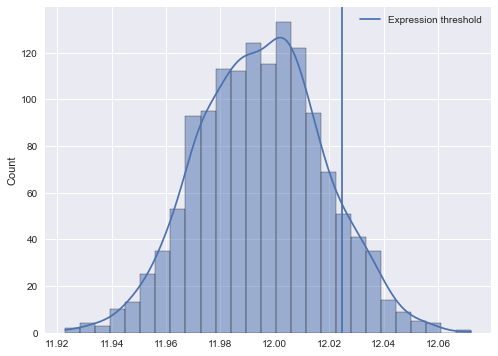

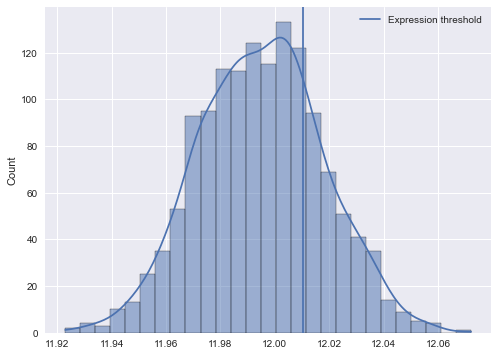

In [50]:
p90_threshold.plot()
p75_threshold.plot()

## Visualizing gene data

In [16]:
gene_data_dict = {k: GeneData(data=v, 
                              data_transform=lambda x: np.log2(x), 
                              absent_expression=-np.inf) 
                  for k, v in raw_count.items()}

In [17]:
gene_data_dict

{'sample_0': <pipeGEM.data.data.GeneData at 0x213c203b250>,
 'sample_1': <pipeGEM.data.data.GeneData at 0x213c203b8b0>,
 'sample_2': <pipeGEM.data.data.GeneData at 0x213c203b880>,
 'sample_3': <pipeGEM.data.data.GeneData at 0x213c203ba90>,
 'sample_4': <pipeGEM.data.data.GeneData at 0x213c203bbe0>,
 'sample_5': <pipeGEM.data.data.GeneData at 0x213c203bd60>,
 'sample_6': <pipeGEM.data.data.GeneData at 0x213c203beb0>,
 'sample_7': <pipeGEM.data.data.GeneData at 0x213c203b1c0>,
 'sample_8': <pipeGEM.data.data.GeneData at 0x213c2041040>}

In [28]:
agg_data = GeneData.aggregate(gene_data_dict, prop="data")

In [19]:
corr_result = agg_data.corr()

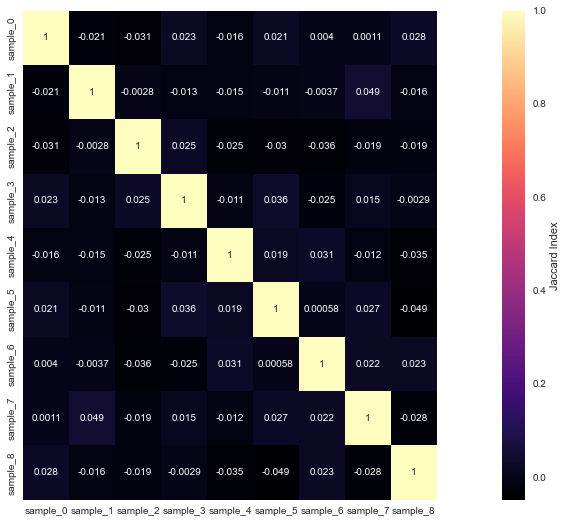

In [22]:
corr_result.plot()

In [32]:
pca_result = agg_data.dim_reduction(method="PCA")

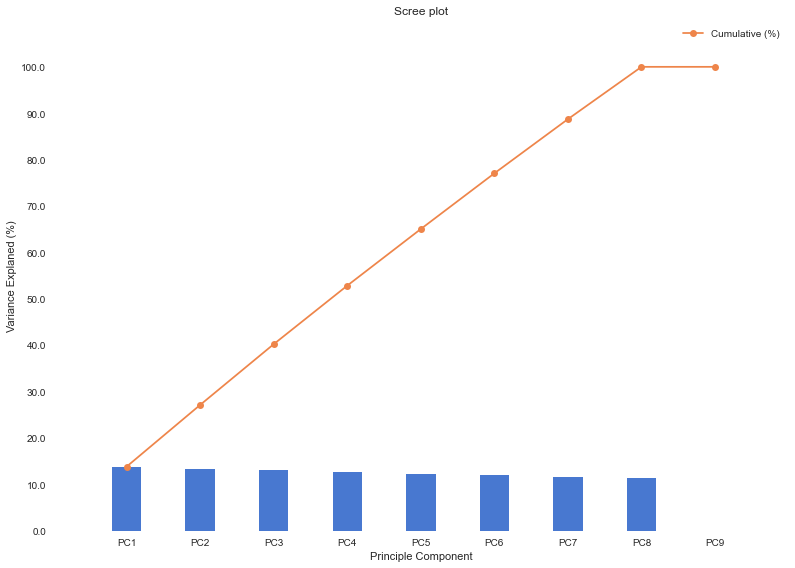

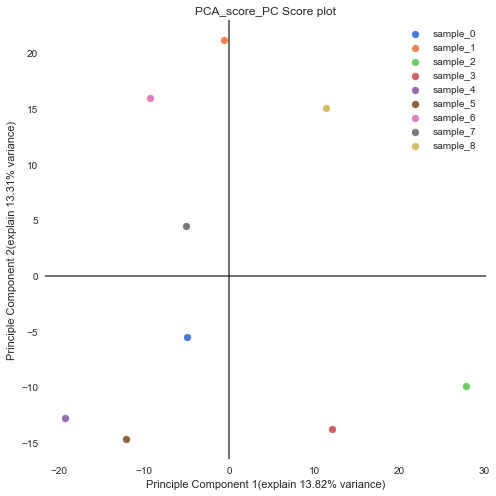

In [34]:
pca_result.plot()

C:\Users\qwert\AppData\Roaming\Python\Python38\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\qwert\AppData\Roaming\Python\Python38\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


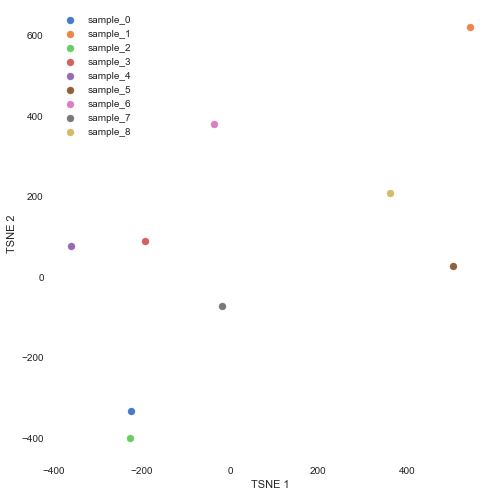

In [36]:
tsne_result = agg_data.dim_reduction(method="TSNE")
tsne_result.plot()

C:\Users\qwert\miniconda3\envs\py38\lib\site-packages\umap\umap_.py:2344: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


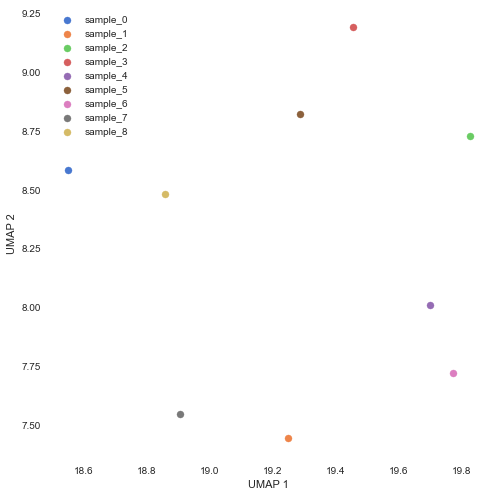

In [37]:
tsne_result = agg_data.dim_reduction(method="UMAP")
tsne_result.plot()

## Medium data

In [7]:
human = load_remote_model("Human-GEM")

Model Human-GEM is already downloaded
Set parameter Username
Academic license - for non-commercial use only - expires 2023-06-14


In [8]:
human.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
MAM01291e,MAR00566,0.3888,22,0.01%
MAM01771e,MAR00567,0.01104,20,0.00%
MAM01371e,MAR00569,1000,10,10.44%
MAM01741e,MAR00571,0.1629,22,0.00%
MAM01689e,MAR00573,0.4173,22,0.01%
MAM00094e,MAR00575,0.1049,22,0.00%
MAM01696e,MAR00576,3.583,20,0.07%
MAM02648e,MAR00577,0.6377,20,0.01%
MAM01432e,MAR00618,0.01104,26,0.00%
MAM02456e,MAR00620,0.01104,17,0.00%
